In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from PIL import Image
from psycopg2 import connect
import matplotlib.image as img

In [15]:
credentials_file = pd.read_csv("./pw_felix.csv")
PG_ADRESS = 'weathertop.ipd.kit.edu'
PG_PORT = '5432'
PG_USERNAME = credentials_file["username"][0]
PG_PW = credentials_file["password"][0]
PG_DBNAME = 'netdissect'
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=PG_USERNAME,
                        password=PG_PW,
                        ipaddress=PG_ADRESS,
                        port=PG_PORT,
                        dbname=PG_DBNAME))
cnx = create_engine(postgres_str)
conn = connect(
        dbname = "netdissect",
        user = credentials_file["username"][0],
        host = "weathertop.ipd.kit.edu",
        password = credentials_file["password"][0],
        # attempt to connect for 3 seconds then raise exception
        connect_timeout = 3
    )
cur = conn.cursor()

In [68]:
pd.read_sql_query('''
    select avg(IoU), label_id, neuron_id,label_type
from (
    select label_type, neuron_id,label_id,ST_Area(St_Intersection(region,focus_region)) / ST_Area(ST_Union(region,focus_region)) as IoU
	from (select * from mask TABLESAMPLE SYSTEM (1) where image_id in (select * from team2.image_sample)) as filteredMask
		join team2.focus_regions TABLESAMPLE SYSTEM (1)
		on team2.focus_regions.image_id = filteredMask.image_id
) as allIoUs
group by label_id, label_type,neuron_id
''',cnx)

KeyboardInterrupt: 

In [ ]:
pd.read_sql_query('''
    select avg(IoU), label_id, neuron_id,label_type
from (
    select label_type, neuron_id,label_id,ST_Area(St_Intersection(region,focus_region)) / ST_Area(ST_Union(region,focus_region)) as IoU
	from mask TABLESAMPLE SYSTEM (1)
        join team2.image_sample 
        on mas
		join team2.focus_regions TABLESAMPLE SYSTEM (1)
		on team2.focus_regions.image_id = filteredMask.image_id
) as allIoUs
group by label_id, label_type,neuron_id
''',cnx)

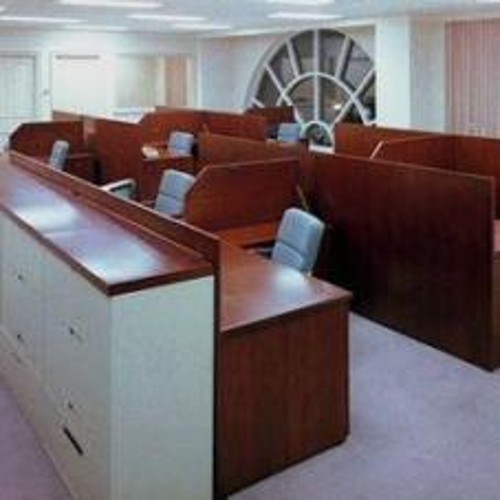

In [75]:
pgImage=pd.read_sql_query('''
    select unnest(ST_Dumpvalues(raster,1)) as r,unnest(ST_Dumpvalues(raster,2)) as g,unnest(ST_Dumpvalues(raster,3)) as b from image where id=46932;
''',cnx)

#activation=pd.read_sql_query('''select unnest(ST_DumpValues(ST_AsRaster(focus_region,227,227),1))
# as act from team2.focus_regions where image_id=46932 and neuron_id=772; ''',cnx)
activation = pd.read_sql_query(''' select a.x as x,a.y as y from
    (select (ST_PixelAsPoints(ST_AsRaster(focus_region,1.0,1.0),1)).*
    as act from team2.focus_regions where image_id=46932 and neuron_id=772
    ) as a;''',cnx)
activation = (list(activation["x"]),list(activation["y"]))

#label = pd.read_sql_query('''select unnest(ST_DumpValues(ST_AsRaster(ST_Union(region),227,227),1))
# as l from mask where image_id=46932 and label_id=36 group by image_id,label_id; ''',cnx)
#label = pd.read_sql_query('''select unnest(ST_DumpValues(ST_AsRaster(a.region,227,227),1))
# as l from (select * from mask where image_id=46932 and label_id=36 limit 1) as a; ''',cnx)
label = pd.read_sql_query('''select a.x as x,a.y as y from
	( select (ST_PixelAsPoints(ST_AsRaster(ST_Union(region),1.0,1.0),1)).*
	 from mask where image_id=46932 and label_id=36 group by image_id,label_id
	 )as a;''',cnx)
label = (list(label["x"]),list(label["y"]))
t=(227,227,3)
A=np.zeros(t,np.uint8)
for i in range(227):
    for j in range (227):
        A[i,j]=[pgImage["r"][i*227+j],pgImage["g"][i*227+j],pgImage["b"][i*227+j]]
        if (i,j) in activation:
            #A[i,j][0]= (A[i,j][0] + 100) % 256
            A[i,j][0]= 255
        
        if (i,j) in label:
            A[i,j][2]= 255
        
i = Image.fromarray(A,"RGB")
i.resize((500,500))

In [16]:
def visualizeImage(image_id,label_id, neuron_id):
  pgImage=pd.read_sql_query(f'''
      select unnest(ST_Dumpvalues(raster,1)) as r,unnest(ST_Dumpvalues(raster,2)) as g,unnest(ST_Dumpvalues(raster,3)) as b from image where id={image_id};
  ''',cnx)

  activation = pd.read_sql_query(f'''
      WITH raster AS (
    SELECT ST_AddBand(ST_MakeEmptyRaster(227, 227, 0, 0, 1), '8BUI'::text) rast
  ), 
  polyasraster AS (
    SELECT ST_AsRaster(focus_region, rast) polyrast
    FROM raster, (SELECT focus_region 
                  FROM team2.focus_regions
                  WHERE image_id={image_id} AND neuron_id={neuron_id}) foo
  )
  SELECT unnest((ST_Dumpvalues(ST_MapAlgebra(rast, polyrast, '[rast1] + [rast2]', extenttype := 'FIRST'))).valarray) rast
  FROM raster, polyasraster;
    ''',cnx)

  if len(activation["rast"]) == 0:
    print("No activation")
    return

  label = pd.read_sql_query(f'''
      WITH raster AS (
    SELECT ST_AddBand(ST_MakeEmptyRaster(227, 227, 0, 0, 1), '8BUI'::text) rast
  ), 
  polyasraster AS (
    SELECT ST_AsRaster(allLabels, rast) polyrast
    FROM raster, (SELECT ST_Union(region) as allLabels
                  FROM mask
                  WHERE image_id={image_id} and label_id={label_id}
                  group by image_id,label_id) foo
  )
  SELECT unnest((ST_Dumpvalues(ST_MapAlgebra(rast, polyrast, '[rast1] + [rast2]', extenttype := 'FIRST'))).valarray) rast
  FROM raster, polyasraster;
    ''',cnx)


  t=(227,227,3)
  A=np.zeros(t,np.uint8)
  for i in range(227):
      for j in range (227):
          A[i,j]=[pgImage["r"][i*227+j],pgImage["g"][i*227+j],pgImage["b"][i*227+j]]
          if not pd.isna(activation["rast"][i*227+j]):
              #A[i,j][0]= (A[i,j][0] + 100) % 256
              A[i,j][0]= 255
          
          if not pd.isna(label["rast"][i*227+j]):
              A[i,j][2]= 255
          
  i = Image.fromarray(A,"RGB")
  return i.resize((500,500))

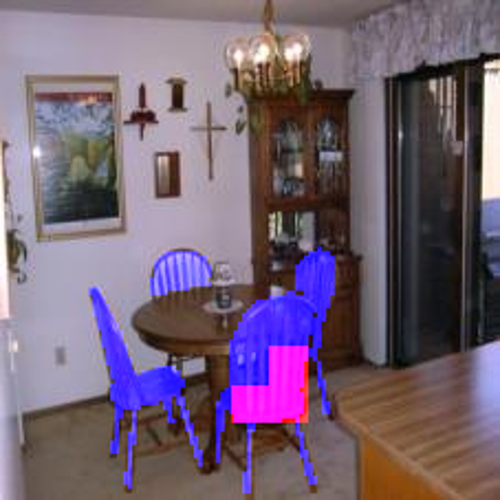

In [52]:
visualizeImage(21450,36,966)
#image_id,label_id,neuron_id

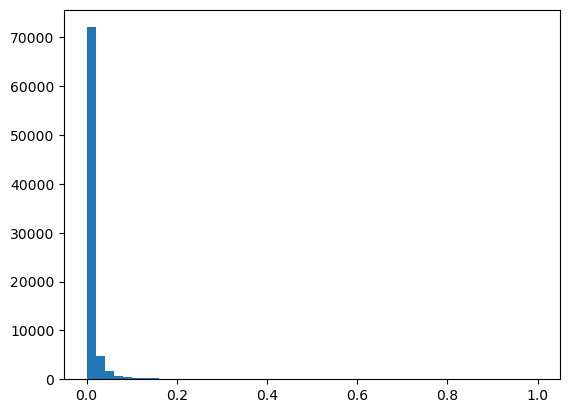

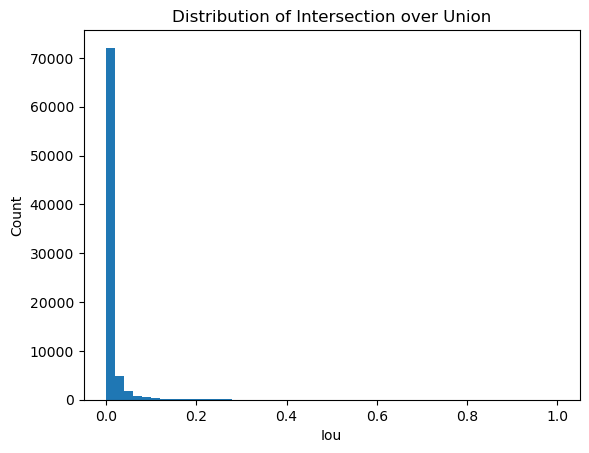

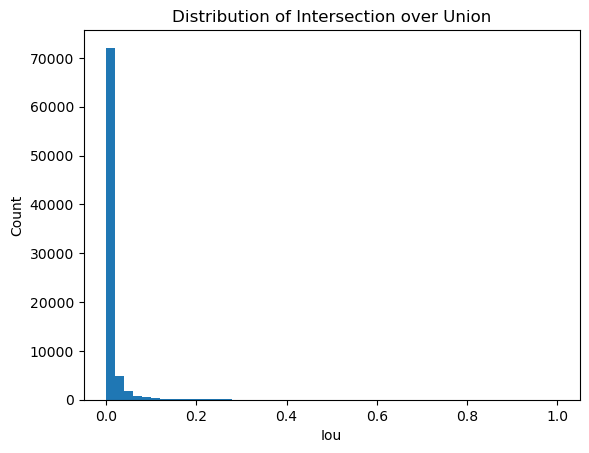

In [159]:
avg_values = pd.read_sql_query('''select avg from team2.iou2''',cnx)
#plt.hist(avg_values.value_counts())
fix, ax = plt.subplots()
ax.hist(avg_values["avg"],bins=50)
ax.set_ylabel('Count')
ax.set_xlabel('Iou')
ax.set_title('Distribution of Intersection over Union')
plt.show()